In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from datetime import datetime
import time
import torchvision.transforms as transforms
import my_transform
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
import net
import sys
import data_utils
import bird_dataset
import os
import stat_utils

In [2]:
# 预处理
use_cache = True # 是否使用缓存，下方变量修改时，需要禁用缓存
rating_min = 3.5 # [0-5]评级最低值，低于此值则删除数据
use_premphasis = True  # 预加重
use_remove_silence = True # 静音片段移除（需要同步调整crop_len）
top_db = 30 # [0-80] 过滤的分贝大小，80为不过滤，0为全过滤
# 训练与预测裁剪
crop_len = 224
crop_step = int(crop_len * 0.8)
fill_length = crop_len # 需要相等，否则会多出空白页面
# 数据增强
use_tanh = False
tanh_noise_std = 0.01 # 0.02还行，注意！不能设置为0
gaussian_noise_std = 0.0
mix_up_radio = 0.0 # 0.005还行
use_norm = False
# 特征融合
use_location = True
location_len = 512
# 训练相关
num_load_processes = None # 并行处理读取和预处理操作（None值为所有核心）
batch_size = 8
valid_size = 0.2
num_epochs = 50
adam_lr = 3e-4
weight_decay = 1e-4 # L2正则化
model_type = 'resnet18'
num_channels = 1
fixed_sampler = True # 固定大部分随机过程（便于测试）
use_evaluate = True # 使用评估模式（不进行训练，显示评估结果）
# 数据路径
csv_path = '/Users/q/Develop/Dataset/CLEF_2021_2023/10x300.csv'
# csv_path = '/Users/q/Develop/Dataset/CLEF_2021_2023/100x300.csv'
audio_path = '/Users/q/Develop/Dataset/CLEF_2021_2023/train_audio/'
pretrained_model = None # 预训练模型路径
pretrained_model = '/Users/q/Develop/Dataset/CLEF_2021_2023/10x300_best_model_95.63%.pt'
# （MFCC超参数按照论文参考，暂时不调整）

In [7]:
if fixed_sampler:
    np.random.seed(41)
    torch.manual_seed(41)

dataset = bird_dataset.BirdDataSet(csv_path=csv_path,
                                   audio_path=audio_path,
                                   fill_length=fill_length,
                                   rating_min=rating_min,
                                   use_premphasis=use_premphasis,
                                   use_remove_silence=use_remove_silence,
                                   top_db=top_db,
                                   use_location=use_location,
                                   use_cache=use_cache,
                                   num_load_processes=num_load_processes)
# 数据增强
transform = transforms.Compose([
    my_transform.RandomHorizontalCrop(crop_len),
    my_transform.GaussianNoise(gaussian_noise_std),
    my_transform.MixUp(dataset=dataset, ratio=mix_up_radio),
    my_transform.TanhDistortion(tanh_noise_std, use_tanh),
    my_transform.Normalize(use_norm=use_norm)
])
tanh_transform = transforms.Compose([
    my_transform.TanhDistortion(tanh_noise_std, use_tanh),
    my_transform.Normalize(use_norm=use_norm)
])
train_loader, valid_dataset = data_utils.get_train_loader_and_valid_dataset(dataset=dataset,
                                                                            valid_size=valid_size,
                                                                            batch_size=batch_size,
                                                                            train_transform=transform)

# model, criterion, optimizer
device = torch.device('mps')
if pretrained_model is None:
    model = net.Net(num_channels=num_channels, num_classes=dataset.classes_num,
                    model_type=model_type, location_len=location_len, device=device, use_location=use_location).to(device)
else:
    model = torch.load(pretrained_model).to(device)
    if not use_evaluate:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.resnet.fc.parameters(): # ResNet的最后一个全连接层
            param.requires_grad = True
        for param in model.fc_a.parameters(): # 后加的全连接层a
            param.requires_grad = True
        model.fc_b = nn.Linear(2048, dataset.classes_num).to(device) # 最后一层类别数换掉
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)

Number of classes: 10
Number of audios: 2290 (src: 3000)
'10x300.pt' is exists!
loading...
Running time: 1.41 s
Size of audio_data: 3.13 GB


使用预训练模型：/Users/q/Develop/Dataset/CLEF_2021_2023/10x300_best_model_95.63%.pt
特征向量维度信息：[1, 224, 224]
Time:[19:00:24] -> 开始迭代
(0.9572393149178865, 0.9560245974846815, 0.9563759836885394)


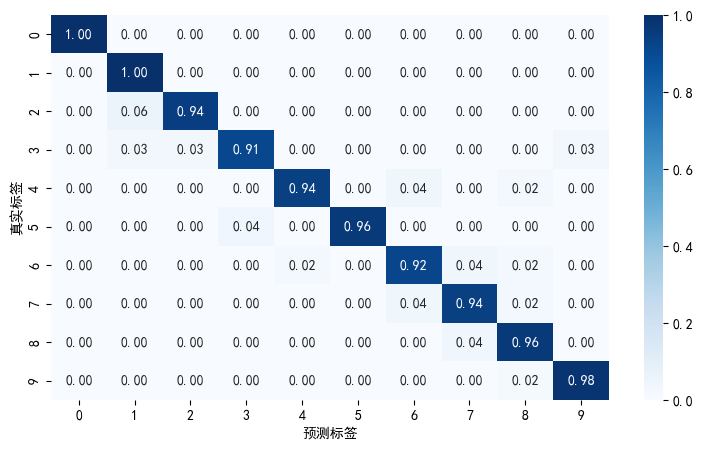

Exception: 评估模式，提取终止程序！

In [8]:
%%time
writer = SummaryWriter()
vector_info = list(valid_dataset[0][0].shape[0:2])
vector_info.append(crop_len)
if pretrained_model is not None:
    print(f"使用预训练模型：{pretrained_model}")
else:
    print(f"使用初始模型：{model_type}")
print(f"特征向量维度信息：{vector_info}")
print(f"Time:[{datetime.now().strftime('%H:%M:%S')}] -> 开始迭代")
# 保存最优模型
best_valid_loss = 1e6
best_model = None
best_model_save_path = os.path.splitext(csv_path)[0] + "_best_model.pt"
# 开始训练
for epoch in range(num_epochs):
    # ————————————————————train————————————————————
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for i, (audio, location, target) in enumerate(train_loader):
        if use_evaluate:
            break
        # 0.GPU
        audio = audio.to(device)
        location = location.to(device)
        target = target.to(device)
        # 1. 计算损失
        output = model(audio, location)
        loss = criterion(output, target)
        # 2. 计算梯度
        optimizer.zero_grad()
        loss.backward()
        # 3. 更新梯度
        optimizer.step()
        # 4. 计算总Loss和Acc
        train_loss += loss.item() * audio.size(0)
        _, predicts = torch.max(output, 1)
        train_acc += torch.sum(predicts == target)

        # 查看过程
        # if (i+1) % 1 == 0:
        #     print(
        #         f"Batch:[{i + 1}/{math.ceil(len(train_loader.sampler)/batch_size)}] \t"
        #         f"Train_loss:{loss:.6f} \t"
        #     )

        # 用于测试，提前终止
        # if i == 0:
        #     break

    # 计算平均Loss和Acc
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)


    # ————————————————————valid————————————————————
    with torch.no_grad():
        valid_loss = 0.0
        valid_acc = 0.0
        pred_list = []
        truth_list = []
        model.eval()

        for i, (audio, location, target) in enumerate(valid_dataset):
            # 分割数据并堆叠
            stacked_tensor = data_utils.crop_with_rule(audio, crop_len, crop_step,
                                                       crop_max_num=batch_size) # torch.Size([2, 1, 128, 1024])
            # 验证集也通过相同的数据增强操作
            stacked_tensor = tanh_transform(stacked_tensor)
            # GPU
            stacked_tensor = stacked_tensor.to(device)
            location = location.to(device)
            target = torch.tensor([target])
            target = target.to(device)
            # 运行模型
            location_repeated = location.repeat(stacked_tensor.shape[0], 1)
            outputs = model(stacked_tensor, location_repeated)
            output = torch.mean(outputs, dim=0, keepdim=True)
            # 计算损失
            loss = criterion(output, target)
            # 4. 计算总Loss和Acc
            valid_loss += loss.item() * audio.size(0)
            _, predicts = torch.max(output, 1)
            valid_acc += torch.sum(predicts == target)
            # 计算评估结果
            if use_evaluate:
                truth_list.append(target.item())
                pred_list.append(predicts.item())
            # 用于测试，提前终止
            # if i == 0:
            #     break
        if use_evaluate:
            print(stat_utils.get_precision_recall_f1(pred=pred_list, truth=truth_list))
            confusion_matrix = stat_utils.get_confusion_matrix(pred=pred_list, truth=truth_list)
            stat_utils.show_heatmap(confusion_matrix)
            raise Exception("评估模式，提取终止程序！")
        # 计算平均Loss和Acc
        valid_loss /= len(valid_dataset)
        valid_acc /= len(valid_dataset)

        # 保存最优模型
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = model
            torch.save(best_model, best_model_save_path)

    print(
        f"Time:[{datetime.now().strftime('%H:%M:%S')}] \t"
        f"Epoch:[{epoch+1}/{num_epochs}] \t"
        f"Train_loss:{train_loss:.3f} \t"
        f"Valid_loss:{valid_loss:.3f} \t"
        f"Train_acc:{train_acc * 100:.2f}% \t"
        f"Valid_acc:{valid_acc * 100:.2f}%"
    )
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/valid', valid_loss, epoch)
    writer.add_scalar('Acc/train', train_acc * 100, epoch)
    writer.add_scalar('Acc/valid', valid_acc * 100, epoch)